# Principal Component Analysis

The present notebook present PCA on the CIFAR-10 dataset. The dataset can be
found <a href="https://www.cs.toronto.edu/~kriz/cifar.html">here</a>.We've used only a subest of the whole dataset due to limit


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def plot_rgb(imgs, grid_i=None, grid_j=None):

    how_many = len(imgs)

    if how_many == 1:
        img = imgs[0]
        fig, ax = plt.subplots()
        ax.imshow(img)
        ax.axis("off")
    else:
        fig, ax = plt.subplots(grid_i, grid_j, figsize=(8, 8))
        for i in range(grid_i):
            for j in range(grid_j):

                ax[i, j].imshow(imgs[grid_i * i + j])
                ax[i, j].axis("off")

    plt.show()

def plot_grayscale(imgs, reshape=False, grid_i=None, grid_j=None):

    if reshape:
        imgs = [img.reshape(32, 32) for img in imgs]

    how_many = len(imgs)

    if how_many == 1:
        img = imgs[0]
        fig, ax = plt.subplots()
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    else:
        fig, ax = plt.subplots(grid_i, grid_j, figsize=(8, 8))
        for i in range(grid_i):
            for j in range(grid_j):

                ax[i, j].imshow(imgs[grid_i * i + j], cmap="gray")
                ax[i, j].axis("off")

    plt.show()

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The classes in the dataset are:
- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

In [ ]:
D = unpickle("./cifar-10-batches-py/data_batch_1")
D.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

We are going to use only one batch from the data, which consists of 10000 images.

Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

In [ ]:
X = D[b"data"]
print(f"Shape = {X.shape} Dtype = {X.dtype}")

Shape = (10000, 3072) Dtype = uint8


In [ ]:
# Preprocessing step.
X = X.astype("float")

R = X[:, :1024]
G = X[:, 1024:2048]
B = X[:, 2048:]

R = R.reshape(10000, 32, 32, 1) / 255
G = G.reshape(10000, 32, 32, 1) / 255
B = B.reshape(10000, 32, 32, 1) / 255

X = np.concatenate([R, G, B], axis=3)
print(f"Shape = {X.shape} Dtype = {X.dtype}")

Shape = (10000, 32, 32, 3) Dtype = float64


In [ ]:
ixs_for_plot = np.linspace(0, 10000 - 1, 4, dtype=int)
ixs_for_plot

array([   0, 3333, 6666, 9999])

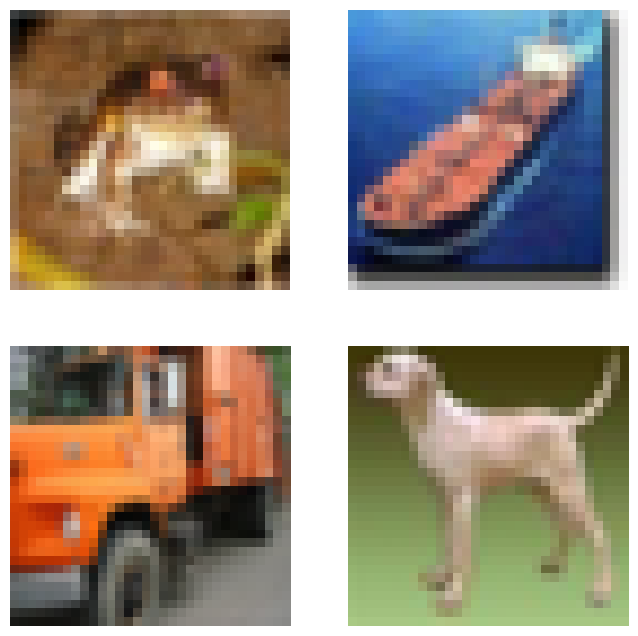

In [ ]:
plot_rgb(X[ixs_for_plot], grid_i=2, grid_j=2)

In [ ]:
# To single channel.
# https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_rgb_to_gray.html
X = np.average(a=X, axis=3, weights=[0.2125 , 0.7154, 0.0721])
X.shape

(10000, 32, 32)

We can use Principal Component Analysis (PCA) to:
- Reduce the dimensionality of the data, while retaining the key characteristics that keep them different (the variance).
- Decorrelate and/or whiten the data

We will perform PCA with two ways and show that they are equivalent:
- Eigenvalue decomposition of the data covariance matrix.
- Singular value decomposition (SVD)

In [ ]:
X = X.reshape(10000, 1024)
m = np.mean(X, axis=0)
# Center the data.
X = X - m

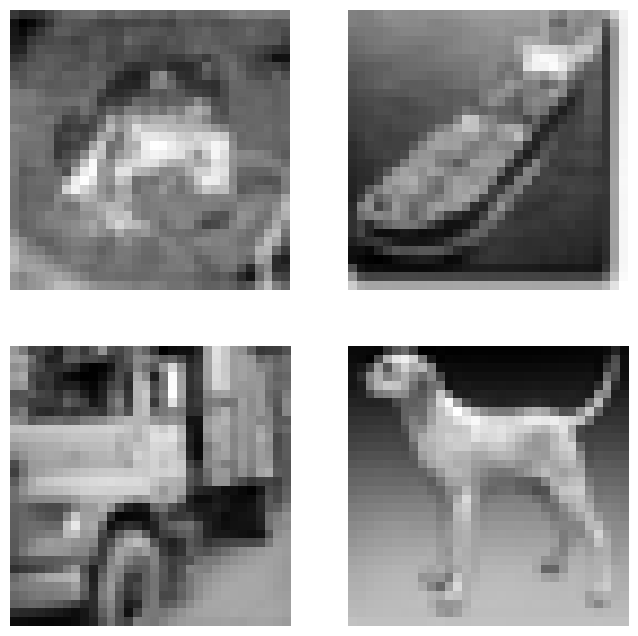

In [ ]:
plot_grayscale(X[ixs_for_plot], reshape=True, grid_i=2, grid_j=2)

### Eigendecomposition of the data covariance matrix

In [ ]:
# Compute the covariance matrix.
C = np.cov(X, rowvar=False)
print(f"Shape of covariance matrix C: {C.shape}")

Shape of covariance matrix C: (1024, 1024)


We start with the centered data matrix $X \, (n \times d)$.<br>
We can compute the covariance matrix $C \, (d \times d)$ as:
$$ C = \frac{X^{T} \times X}{n-1} $$

The eigendecomposition of the covariance matrix:
$$ C = Λ \times Δ \times Λ^{T} $$
where:
- $Δ \, (d \times d)$ is a diagonal matrix, with the eigenvalues along the diagonal (in descending order)
- $Λ \, (d \times d)$ is an orthogonal matrix, with the eigenvectors as columns (ordered w.r.t. their eigenvalues)

In [ ]:
# Perform the eigendecomposition of the covariance matrix. Sort the eigen* in descending order of the eigenvalues.
eigenvalues, eigenvectors = np.linalg.eigh(a=C)

sorted_eigval_ix = np.argsort(a=eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_eigval_ix]
sorted_eigenvectors = eigenvectors[:, sorted_eigval_ix]

L = sorted_eigenvectors
D = np.diag(v=np.where(sorted_eigenvalues > 0, sorted_eigenvalues, 0))

print(f"Shape of eigenvector matrix L: {V.shape}")
print(f"Shape of eigenvalue matrix D: {L.shape}")

Shape of eigenvector matrix L: (1024, 1024)
Shape of eigenvalue matrix D: (1024, 1024)


In [ ]:
# Check that the eigendecomposition of C holds.
np.allclose(C, L @ D @ L.T)

True

In [ ]:
# Compute the percentage of variance that each component explains.
# Then we can find how many components we need to explain 95% of the variance.
explained_variance = sorted_eigenvalues / np.sum(sorted_eigenvalues)
k_range = list(range(1, X.shape[1] + 1))
explained_variance_for_k = np.cumsum(explained_variance)
explained_variance_for_k

array([0.30637459, 0.43182455, 0.50386159, ..., 0.99999896, 0.9999995 ,
       1.        ])

In [ ]:
k = np.argmax(explained_variance_for_k >= 0.95)
k

155

$Λ_{k}$ is the matrix of the $k$ eigenvectors that correspond to the $k$ biggest eigenvalues of the covariance matrix.<br>
We can reduce the dimensionality of (and decorrelate) the data by multiplying each sample with $Λ_{k}^{T}$.
$$
\begin{align*}
    RD &= (Λ_{k}^{T} \times X^{T})^{T} \\
    RD &= X \times Λ_{k}
\end{align*}
$$
where $RD$ is the reduced dimensionality representation of $X$.

In [ ]:
reduced_X = X @ L[:, :k]
reduced_X.shape

(10000, 155)

From $RD$ we can approximately reconstruct the original data $X$ as follows:
$$ RC = RD \times Λ_{k}^{T} + μ$$
where $RC$ is the reconstructed representation of $X$ and $μ$ is the mean vector of $X$.

In [ ]:
reconstr_X = reduced_X @ L[:, :k].T + m
reconstr_X.shape

(10000, 1024)

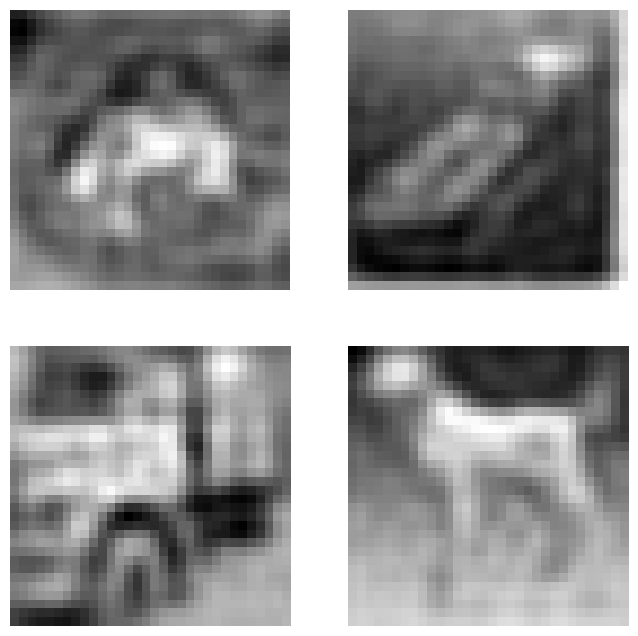

In [ ]:
plot_grayscale(reconstr_X[ixs_for_plot], reshape=True, grid_i=2, grid_j=2)

### SVD

SVD breaks down the data matrix $X \,$ into three matrices:
- $U \, (n \times n)$
- $Σ \, (n \times d)$
- $V^{T} \, (d \times d)$

where $X = U \times Σ \times V^{T}$

In [ ]:
U, sigma, Vt = np.linalg.svd(X)
print(f"Shape of U: {U.shape}")
print(f"Shape of sigma: {sigma.shape}")
print(f"Shape of V.T: {Vt.shape}")

Shape of U: (10000, 10000)
Shape of sigma: (1024,)
Shape of V.T: (1024, 1024)


We can reduce the dimensionality of (and decorrelate) the data by multiplying each sample with $V_{k}^{T}$.
$$
\begin{align*}
RD' &= (V_{k}^{T} \times X^{T})^{T} \\
RD' &= X \times V_{k}
\end{align*}
$$
where $RD'$ is the reduced dimensionality representation of $X$.

In [ ]:
reduced_X_svd = (Vt[:k, :] @ X.T).T
reduced_X_svd.shape

(10000, 155)

From $RD'$ we can approximately reconstruct the original data $X$ as follows:
$$ RC' = RD' \times V_{k}^{T} + μ$$
where $RC'$ is the reconstructed representation of $X$ and $μ$ is the mean vector of $X$.

In [ ]:
reconstr_X_svd = (Vt[:k, :].T @ reduced_X_svd.T).T + m
reconstr_X_svd.shape

(10000, 1024)

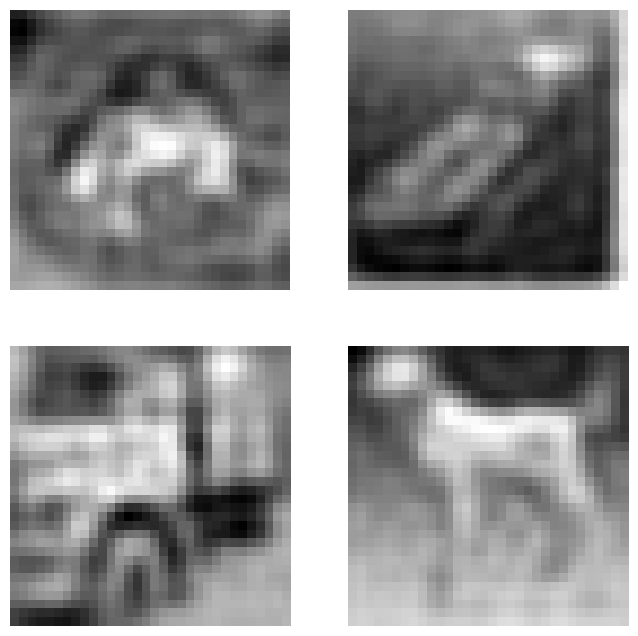

In [ ]:
plot_grayscale(reconstr_X_svd[ixs_for_plot], reshape=True, grid_i=2, grid_j=2)

We now want to show that the two processes are equivalent in terms of the reconstructed matrix:
$$ RC = RC'$$

The eigendecomposition of the covariance matrix is defined as:
$$ C = Λ \times Δ \times Λ^{T} $$
The covariance matrix can be expressed as:
$$ C = \frac{X^{T} \times X}{n-1} $$
The SVD is defined as:
$$X = U \times Σ \times V^{T}$$

We can deduce from above that:
$$
\begin{align*}
C &= Λ \times Δ \times Λ^{T} \Leftrightarrow \\
\frac{X^{T} \times X}{n-1} &= Λ \times Δ \times Λ^{T} \Leftrightarrow \\
\frac{(U \times Σ \times V^{T})^{T} \times (U \times Σ \times V^{T})}{n-1} &= Λ \times Δ \times Λ^{T} \Leftrightarrow \\
\frac{(V \times Σ^{Τ} \times U^{T}) \times (U \times Σ \times V^{T})}{n-1} &= Λ \times Δ \times Λ^{T} \Leftrightarrow \\
V \times \frac{Σ^{Τ} \times Σ}{n-1} \times V^{T} &= Λ \times Δ \times Λ^{T}
\end{align*}
$$

So we can see that:
$$
\begin{align*}
V &= Λ \\
\frac{Σ^{Τ} \times Σ}{n-1} &= Δ
\end{align*}
$$

From the definitions of $RD, RC, RD'$ and $RC'$ we can see that since: $V = Λ$ then $RC = RC'$.

In [ ]:
np.allclose(reconstr_X, reconstr_X_svd)

True